In [1]:
!pip install efficientnet_pytorch
!pip install git+https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git

  Stored in directory: /home/itm1/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
  Cloning https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git to /tmp/pip-req-build-6my87q5p
  Running command git clone -q https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git /tmp/pip-req-build-6my87q5p
  Stored in directory: /tmp/pip-ephem-wheel-cache-39pwp6bv/wheels/5a/b7/09/d748b20c9bdfc768a33c37a28b2ad7dd9ec3e79e5152cb1618
Successfully built torch-poly-lr-decay


In [1]:
import torch
import glob
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import KFold
import time
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from torch_poly_lr_decay import PolynomialLRDecay
import random
from PIL import Image


torch.set_num_threads(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#dataload
labels_df = pd.read_csv('dataset/dirty_mnist_2nd_answer.csv')[:]
imgs_dir = np.array(sorted(glob.glob('dataset/dirty_mnist_2nd/*')))[:]
labels = np.array(labels_df.values[:,1:])

test_imgs_dir = np.array(sorted(glob.glob('dataset/test_dirty_mnist_2nd/*')))
imgs=[]
for path in tqdm(imgs_dir[:]):
    img=cv2.imread(path, cv2.IMREAD_COLOR)
    imgs.append(img)
imgs=np.array(imgs)

100%|██████████| 50000/50000 [00:34<00:00, 1463.91it/s]


In [34]:
image = Image.open('dataset/dirty_mnist_2nd/00002.png')

In [3]:
# 저장소에서 load
class MnistDataset_v1(Dataset):
    def __init__(self, imgs_dir=None, labels=None, transform=None, train=True):
        self.imgs_dir = imgs_dir
        self.labels = labels
        self.transform = transform
        self.train = train
        pass
    
    def __len__(self):
        # 데이터 총 샘플 수
        return len(self.imgs_dir)
    
    def __getitem__(self, idx):
        # 1개 샘플 get
        #img = cv2.imread(self.imgs_dir[idx], cv2.IMREAD_COLOR)
        img = Image.open(self.imgs_dir[idx]).convert('RGB')
        img = self.transform(img)
        if self.train==True:
            label = self.labels[idx]
            return img, label
        else:
            return img
        
        pass
    


# 메모리에서 load
class MnistDataset_v2(Dataset):
    def __init__(self, imgs=None, labels=None, transform=None, train=True):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.train=train
        pass
    
    def __len__(self):
        # 데이터 총 샘플 수
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # 1개 샘플 get1
        img = self.imgs[idx]
        img = self.transform(img)
        
        if self.train==True:
            label = self.labels[idx]
            return img, label
        else:
            return img

In [4]:
# https://dacon.io/competitions/official/235697/codeshare/2363?page=1&dtype=recent&ptype=pub
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  

In [5]:
# EfficientNet -b0(pretrained)
# MultiLabel output

class EfficientNet_MultiLabel(nn.Module):
    def __init__(self, in_channels):
        super(EfficientNet_MultiLabel, self).__init__()
        self.network = EfficientNet.from_pretrained('efficientnet-b3', in_channels=in_channels)
        self.output_layer = nn.Linear(1000, 26)

    def forward(self, x):
        x = F.relu(self.network(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

In [21]:
# 해당 코드에서는 1fold만 실행

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in kf.split(imgs):
    folds.append((train_idx, valid_idx))

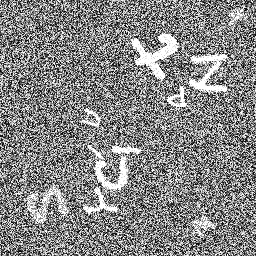

In [55]:
image

In [ ]:

### seed_everything(42)

# 5개의 fold 모두 실행하려면 for문을 5번 돌리면 됩니다.
for fold in range(5):
    model = EfficientNet_MultiLabel(in_channels=3).to(device)
#     model = nn.DataParallel(model)
    train_idx = folds[fold][0]
    valid_idx = folds[fold][1]
    
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
                transforms.ToTensor(),

#         transforms.RandomRotation(random.randint(-30, 30))
        ])
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        ])


    epochs=30
    batch_size=40         # 자신의 VRAM에 맞게 조절해야 OOM을 피할 수 있습니다.
    
    
    
    # Data Loader
    train_dataset = MnistDataset_v1(imgs_dir = imgs_dir[train_idx], labels=labels[train_idx], transform=train_transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = MnistDataset_v1(imgs_dir = imgs_dir[valid_idx], labels = labels[valid_idx], transform=valid_transform)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)       
    
    
    # optimizer
    # polynomial optimizer를 사용합니다.
    # 
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    decay_steps = (len(train_dataset)//batch_size)*epochs
    scheduler_poly_lr_decay = PolynomialLRDecay(optimizer, max_decay_steps=decay_steps, end_learning_rate=1e-6, power=0.9)

    criterion = torch.nn.BCELoss()
    
    
    epoch_accuracy = []
    valid_accuracy = []
    valid_losses=[]
    valid_best_accuracy=0
    
    for epoch in range(epochs):
        model.train()
        batch_accuracy_list = []
        batch_loss_list = []
        start=time.time()
        for n, (X, y) in enumerate((train_loader)):
            X = torch.tensor(X, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            y_hat = model(X)


            optimizer.zero_grad()
            loss = criterion(y_hat, y)
            #gradient accumulation
            if (n+1) % 4 == 0:             # Wait for several backward steps
                total_loss = (total_loss+loss)/ 4 
                loss.backward()
                optimizer.step()                            # Now we can do an optimizer step
                model.zero_grad()                           # Reset gradients tensors
                total_loss=0
                scheduler_poly_lr_decay.step()

            else:
                total_loss=loss+total_loss


            y_hat  = y_hat.cpu().detach().numpy()
            y_hat = y_hat>0.5
            y = y.cpu().detach().numpy()

            batch_accuracy = (y_hat == y).mean()
            batch_accuracy_list.append(batch_accuracy)
            batch_loss_list.append(loss.item())

        print("=========test=========")

        model.eval()
        valid_batch_accuracy=[]
        valid_batch_loss = []
        with torch.no_grad():
            for n_valid, (X_valid, y_valid) in enumerate((valid_loader)):
                X_valid = torch.tensor(X_valid, device=device)#, dtype=torch.float32)
                y_valid = torch.tensor(y_valid, device=device, dtype=torch.float32)
                y_valid_hat = model(X_valid)

                valid_loss = criterion(y_valid_hat, y_valid).item()

                y_valid_hat = y_valid_hat.cpu().detach().numpy()>0.5


                valid_batch_loss.append(valid_loss)
                valid_batch_accuracy.append((y_valid_hat == y_valid.cpu().detach().numpy()).mean())

            valid_losses.append(np.mean(valid_batch_loss))
            valid_accuracy.append(np.mean(valid_batch_accuracy))

        if np.mean(valid_batch_accuracy)>valid_best_accuracy:
            torch.save(model.state_dict(), 'model/EfficientNetB3-fold{}-epoch{}.pt'.format(fold,epoch))
            valid_best_accuracy = np.mean(valid_batch_accuracy)
        print('fold : {}\tepoch : {:02d}\ttrain_accuracy / loss : {:.5f} / {:.5f}\tvalid_accuracy / loss : {:.5f} / {:.5f}\ttime : {:.0f}'.format(fold+1, epoch+1,
                                                                                                                                              np.mean(batch_accuracy_list),
                                                                                                                                              np.mean(batch_loss_list),
                                                                                                                                              np.mean(valid_batch_accuracy), 
                                                                                                                                              np.mean(valid_batch_loss),
                                                                                                                                              time.time()-start))
        with open('./log.txt','a') as f:
            f.write('fold : {}\tepoch : {:02d}\ttrain_accuracy / loss : {:.5f} / {:.5f}\tvalid_accuracy / loss : {:.5f} / {:.5f}\ttime : {:.0f}'.format(fold+1, epoch+1,
                                                                                                                                                               np.mean(valid_batch_accuracy), 
                                                                                                                                              np.mean(valid_batch_loss),
                                                                                                                                              time.time()-start))

Loaded pretrained weights for efficientnet-b3


/home/itm1/anaconda3/envs/py140/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/itm1/anaconda3/envs/py140/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


=========test=========
fold : 1	epoch : 02	train_accuracy / loss : 0.66630 / 0.60073	valid_accuracy / loss : 0.68305 / 0.59131	time : 388
=========test=========
fold : 1	epoch : 03	train_accuracy / loss : 0.72759 / 0.53477	valid_accuracy / loss : 0.74188 / 0.51996	time : 388
=========test=========
fold : 1	epoch : 04	train_accuracy / loss : 0.77323 / 0.47596	valid_accuracy / loss : 0.76044 / 0.49613	time : 388
=========test=========
fold : 1	epoch : 05	train_accuracy / loss : 0.80369 / 0.42917	valid_accuracy / loss : 0.80410 / 0.42916	time : 388
=========test=========
fold : 1	epoch : 06	train_accuracy / loss : 0.82563 / 0.39287	valid_accuracy / loss : 0.82667 / 0.38810	time : 388
=========test=========
fold : 1	epoch : 07	train_accuracy / loss : 0.84234 / 0.36216	valid_accuracy / loss : 0.83640 / 0.37321	time : 389
=========test=========
fold : 1	epoch : 08	train_accuracy / loss : 0.85680 / 0.33469	valid_accuracy / loss : 0.84437 / 0.35923	time : 388
=========test=========
fold : 1	ep

In [6]:
test_imgs=[]
for path in tqdm(test_imgs_dir):
    test_img=cv2.imread(path, cv2.IMREAD_COLOR)
    test_imgs.append(test_img)
test_imgs=np.array(test_imgs)

100%|██████████| 5000/5000 [00:05<00:00, 905.95it/s]


In [7]:
test_transform = transforms.Compose([

        transforms.ToTensor(),
        ])

In [12]:
submission = pd.read_csv('dataset/sample_submission.csv')

with torch.no_grad():
    for fold in range(2):
        model = EfficientNet_MultiLabel(in_channels=3).to(device)
        model.load_state_dict(torch.load('model/EfficientNetB3-fold{}-epoch28.pt'.format(fold)))
        model.eval()

        test_dataset = MnistDataset_v2(imgs = test_imgs, transform=test_transform, train=False)
        test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
        for j in range(3):
            test_dataset = MnistDataset_v2(imgs = test_imgs, transform=test_transform, train=False)
            test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
            for n, X_test in enumerate(tqdm(test_loader)):
                X_test = torch.tensor(X_test, device=device, dtype=torch.float32)
                with torch.no_grad():
                    model.eval()
                    pred_test = model(X_test).cpu().detach().numpy()
                    submission.iloc[n*32:(n+1)*32,1:] += pred_test

  0%|          | 0/5000 [00:00<?, ?it/s]/home/itm1/anaconda3/envs/py140/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
  0%|          | 4/5000 [00:00<02:10, 38.35it/s]

Loaded pretrained weights for efficientnet-b3


  0%|          | 0/5000 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3


100%|██████████| 5000/5000 [02:02<00:00, 40.72it/s]


In [13]:
submission.iloc[:,1:] = np.where(submission.values[:,1:]/2>=0.5, 1,0)


# hard Voting

In [ ]:
submission1 = pd.read_csv('dataset/EfficientNetB1-fold3.csv')
submission2 = pd.read_csv('dataset/densenet121_aug_rotation_20epoch.csv')
submission3 = pd.read_csv('dataset/densenet201_aug_rotation_kfold_0.3056_epoch_17.csv')
submission4 = pd.read_csv('dataset/EfficientNetB3-fold1.csv')
submission5 = pd.read_csv('dataset/EfficientNetB3-fold2.csv')
submission6 = pd.read_csv('dataset/submit_resnet101.csv')
submission7 = pd.read_csv('dataset/resnet152_trained_prediction.csv')
submission8 = pd.read_csv('dataset/densenet201_aug_rotation_kfold_0.3056_epoch_17.csv')

In [ ]:
new = submission1+submission2+submission3+submission4+submission5+submission6+submission7+submission8
submission.iloc[:,1:] = np.where(submission.values[:,1:]>=4, 1,0)

submission = pd.read_csv('dataset/sample_submission.csv')
new['index']=submission['index']